In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!wget http://ekpwww.ekp.kit.edu/~tkeck/realdonaldtrump.csv

--2017-09-19 00:31:24--  http://ekpwww.ekp.kit.edu/~tkeck/realdonaldtrump.csv
Auflösen des Hostnamens »ekpwww.ekp.kit.edu (ekpwww.ekp.kit.edu)« … 129.13.101.178
Verbindungsaufbau zu ekpwww.ekp.kit.edu (ekpwww.ekp.kit.edu)|129.13.101.178|:80 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 5954129 (5,7M) [text/csv]
Wird in »»realdonaldtrump.csv«« gespeichert.

realdonaldtrump.csv 100%[===================>]   5,68M   446KB/s    in 13s     

2017-09-19 00:31:37 (450 KB/s) - »»realdonaldtrump.csv«« gespeichert [5954129/5954129]



In [2]:
import pandas as pd
df = pd.read_csv('realdonaldtrump.csv', parse_dates=[5])
df.head()

,favorite_count,source,text,in_reply_to_screen_name,is_retweet,created_at,retweet_count,id_str
0,17198,Twitter for Android,"""@zhu_amy3: @realDonaldTrump It's Morning in A...",NaN,True,2017-01-12 04:24:52,3510,819399723924803585
1,47078,Twitter for Android,We had a great News Conference at Trump Tower ...,NaN,False,2017-01-12 04:01:38,13591,819393877174087682
2,51040,Twitter for Android,Intelligence agencies should never have allowe...,NaN,False,2017-01-11 12:48:52,17733,819164172781060096
3,51673,Twitter for Android,"I win an election easily, a great ""movement"" i...",NaN,False,2017-01-11 12:44:05,15037,819162968592183298
4,42993,Twitter for Android,Russia has never tried to use leverage over me...,NaN,False,2017-01-11 12:31:31,14087,819159806489591809


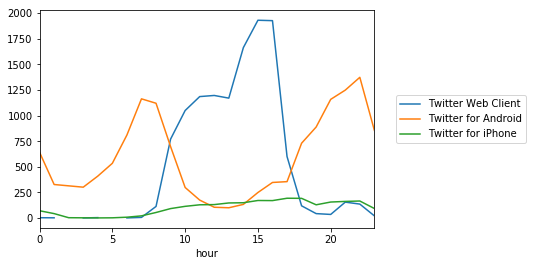

In [3]:
# Localize created_at in New York and add hour as new feature
times = pd.DatetimeIndex(df.created_at).tz_localize('utc').tz_convert('US/Eastern')
df['hour'] = times.hour
# Get the three most common devices in used for the tweets
favorit_devices = df.groupby('source')['id_str'].count().sort_values().index[-3:]
subset = df[df.source.isin(favorit_devices)]
# Count the number of tweets for each device and hour
count = subset.groupby(['source', 'hour'])['id_str'].count()
pivot = count.reset_index().pivot('hour', 'source', values='id_str')
# Plot it
pivot.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

Using TensorFlow backend.


155

In [12]:
text = df[~df.is_retweet].text.str.cat(sep=" ")
print(len(text))
import re
text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
print(len(text))

2151050
1494506


In [13]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [14]:
maxlen = 40
step = 3
tweet_fragments = []
next_character = []
for i in range(0, len(text) - maxlen, step):
    tweet_fragments.append(text[i: i + maxlen])
    next_character.append(text[i + maxlen])

X = np.zeros((len(tweet_fragments), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(tweet_fragments), len(chars)), dtype=np.bool)
for i, tweet_fragment in enumerate(tweet_fragments):
    for t, char in enumerate(tweet_fragment):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_character[i]]] = 1

In [15]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [16]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y,
              batch_size=128,
              epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
 13312/498156 [..............................] - ETA: 1967s - loss: 3.7504